# PDS Analysis
In this notebook the light curves detected by Osborn et al. 2017 of young star, PDS 110, in the Orion OB1 association will be analysed with BeyonCE to determine if there are smaller, better fit model solutions to the data gathered.

## Module Imports
Here we import all the necessary modules for the analysis of the PDS light curves.

In [2]:
# main modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import astropy.units as u

# allow relative imports
import sys
sys.path.append("../")

# shallot grid
from beyonce.shallot import ShallotGrid
from beyonce.grid_parameters import Parameters

# ring system
from beyonce.ring_system import RingSystem


In [3]:
def ring_gradients(x_positions: np.ndarray, dx: float, dy: float, inclination: float, tilt: float) -> np.ndarray:
    ''''
    This function is used to determine the projected gradients for 
    a given ellipse defined by inclination and tilt.

    Parameters
    ----------
    x_positions : np.ndarray (float 1-D)
        These are the positions [space] along which to measure the
        the gradient [R*].
    dx : float
        x-coordinate of the centre of the occulter [R*].
    dy : float
        y-coordinate of the centre of the occulter [R*].
    inclination : float
        Inclination of the occulter (angle w.r.t. LOS) [deg].
    tilt : float
        Angle between occulter semi-major axis and the orbital path [deg].

    Returns
    -------
    gradients : array_like (float 1-D)
        The projected gradients are a transformation of the above tangents.
    '''
    # convert angles to radians
    inc = np.deg2rad(inclination)
    phi = np.deg2rad(tilt)
    
    # transform coordinates to ellipse centre
    x = x_positions - dx
    y = -dy * np.ones_like(x)
    
    # helpers
    numz = np.cos(phi)**2 + np.sin(phi)**2 / np.cos(inc)**2
    denz = np.sin(phi)**2 + np.cos(phi)**2 / np.cos(inc)**2
    z = np.cos(phi) * np.sin(phi) * (1 - 1 / np.cos(inc)**2)
    
    # tangents
    tangents = -(x * numz + z * y) / (y * denz + z * x)

    # gradients
    gradients = np.abs(np.sin(np.arctan2(tangents, 1)))

    return gradients

## PDS Data
The PDS light curve shows two separate eclipses. The first in 2008 was captured by SuperWASP and the second in 2011 was capture (for the most part) by KELT. The light curve data and gradient information is loaded in. The data from the best fit model is also defined here.

#### 2008 SuperWASP Data
Data collected by SuperWASP in 2008.

In [5]:
time_wasp, flux_wasp, flux_error_wasp = np.load('wasp_lightcurve.npy')
slope_time_wasp, slope_wasp, slope_error_wasp = np.load('wasp_gradients.npy')

#### 2011 KELT Data
Data collected by KELT in 2011.

In [6]:
time_kelt, flux_kelt, flux_error_kelt = np.load('kelt_lightcurve.npy')
slope_time_kelt, slope_kelt, slope_error_kelt = np.load('kelt_gradients.npy')

#### Combined Data 
Data is combined for further use.

In [7]:
# light curve data
time = np.concatenate((time_wasp, time_kelt), 0)
flux = np.concatenate((flux_wasp, flux_kelt), 0)
flux_error = np.concatenate((flux_error_wasp, flux_error_wasp), 0)

# gradient data (slope is absolute valued for use with shallot)
slope_time = np.concatenate((slope_time_wasp, slope_time_kelt), 0)
slope = np.abs(np.concatenate((slope_wasp, slope_kelt), 0))
slope_error = np.concatenate((slope_error_wasp, slope_error_kelt), 0)

#### Star and Model Data from Osborn et al. 2017
Here is data from Osborn et al. 2017 as presented in the paper with the corresponding units.

In [8]:
# paper information
paper_disk_radius_pds = 21 * u.d
paper_inclination_pds = 74.76 * u.deg
paper_tilt_pds = 158.62 * u.deg
paper_dx_pds = 4.02 * u.d
paper_dy_pds = 2.45 * u.d
paper_star_radius = 2.23 * u.Rsun 

paper_eclipse_duration = 25 * u.d
paper_transverse_velocity = 27 * u.km / u.s
paper_limb_darkening = 0.8 # -

<strong>Note:</strong> <em>In the paper the impact parameter is defined as the y-offset of the star w.r.t. the occulting disk. The star also moves from left to right, which means we observe the gradients from the left edge of the occulter to the right edge.</em>

The data above are converted for use in this analysis.

In [9]:
# eclipse_duration = paper_eclipse_duration.value

# light curve is convolved with the stellar disk, (increases the duration of the eclipse)
# for this reason it is removed for Shallot Analysis as this does not consider the finite
# size of the star
eclipse_duration = paper_eclipse_duration.value - (2 * paper_star_radius / paper_transverse_velocity).to(u.d).value


limb_darkening = paper_limb_darkening
transverse_velocity = (paper_transverse_velocity * (1 * u.d).to(u.s) / paper_star_radius.to(u.km)).value

disk_radius_pds = (paper_disk_radius_pds / paper_eclipse_duration).value
inclination_pds = paper_inclination_pds.value
tilt_pds = 180 - paper_tilt_pds.value
impact_parameter_pds = - (paper_dy_pds / paper_eclipse_duration).value
centroid_shift_pds = - (paper_dx_pds / paper_eclipse_duration).value

<strong>Note:</strong> <em>in this analysis the impact parameter is defined as the y-offset of the </em><strong>occulter w.r.t. the star</strong><em> and the </em><strong>occulter</strong><em> moves from left to right. This means we observe the gradients from the </em><strong>right</strong><em> edge to the </em><strong>left</strong><em> edge. For this reason the tilt is flipped about the y-axis, and the impact parameter and centroid shift have a flipped sign.</em>

#### Light Curve Data
We plot both eclipses to ensure that the data has been loaded properly.

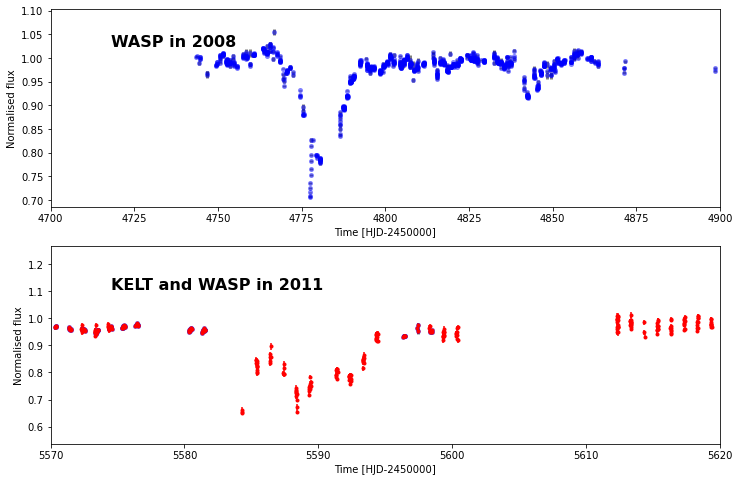

In [10]:
# errorbars definiton
tc = dict(marker='.',ecolor='black', capsize=0 ,
    elinewidth=3, ms=10, alpha = 0.5, markeredgecolor='none',
    markeredgewidth=0.0, linewidth=0.0)

# text in left and corner
tyb = dict(color='black', fontsize=16, fontweight='bold', va='top')

# generate figure
fig = plt.figure(figsize=(12,8))

# 2008 eclipse
ax1 = fig.add_subplot(211)
ax1.set_xlim(4700,4900)
ax1.text(0.09, 0.87, 'WASP in 2008', transform=ax1.transAxes, **tyb)
ax1.errorbar(time_wasp, flux_wasp, flux_error_wasp, mfc='blue', **tc)
ax1.set_xlabel('Time [HJD-2450000]')
ax1.set_ylabel('Normalised flux')

# 2011 eclipse
ax2 = fig.add_subplot(212)
ax2.set_xlim(5570,5620)
ax2.text(0.09, 0.84, 'KELT and WASP in 2011', transform=ax2.transAxes, **tyb)
ax2.errorbar(time_wasp, flux_wasp, flux_error_wasp, mfc='blue', **tc)
ax2.errorbar(time_kelt, flux_kelt, flux_error_kelt, fmt='.', color='red')
ax2.set_xlabel('Time [HJD-2450000]')
ax2.set_ylabel('Normalised flux')

plt.show()

#### Gradient Data
We plot the gradient data and the model from the paper to ensure everything was loaded in correctly.

In [11]:
scale = transverse_velocity * eclipse_duration
positions = scale * np.linspace(-0.75, 0.75, 1001)
gradients = ring_gradients(positions, scale * centroid_shift_pds, scale * impact_parameter_pds, inclination_pds, tilt_pds)
times = -positions / transverse_velocity

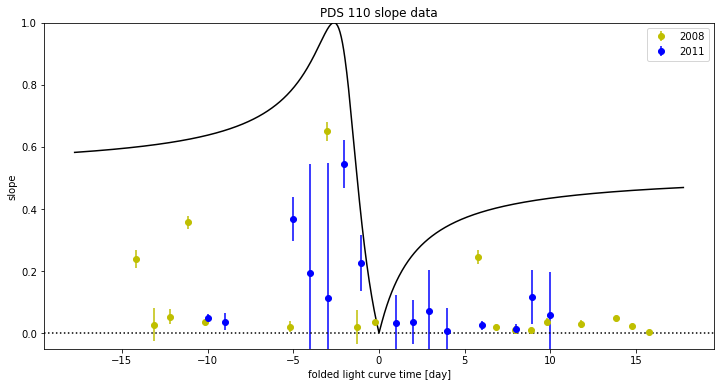

In [12]:
fig = plt.figure(figsize=(12, 6))
plt.errorbar(slope_time_wasp, np.abs(slope_wasp), yerr=slope_error_wasp, fmt='o', color='y', label='2008')
plt.errorbar(slope_time_kelt, np.abs(slope_kelt), yerr=slope_error_kelt, fmt='o', color='b', label='2011')
plt.plot(times, gradients, 'k-')
plt.ylim(-0.05, 1)
plt.gca().axhline(y=0, color='k', ls=':')
plt.xlabel('folded light curve time [day]')
plt.ylabel('slope')
plt.title('PDS 110 slope data')
plt.legend()
plt.show()

The difference between this plot and that of the paper lies in the fact that the gradients here are not multiplied by a scale factor of 0.7 to reduce the height of the curve. This comes from varying the total transmission of the disk from 0.0 to 0.3. This will be addressed later.

## BeyonCE - Shallot Grid Analysis
Here we will use BeyonCE - Shallot Grid to explore the parameter space of circumplanetary disks that are possible solutions to this system, with the specified parameters. We will attempt to find better fit solutions that are smaller than the current solution and compare them appropriately.

#### Shallot Grid Creation
We attempt to load the shallot grid other wise generate it.

In [14]:
try:
    grid = ShallotGrid.load('../coarse_grid')
except Exception:
    parameters = Parameters(0, 1, 101, 0, 1, 251, 5, 201)
    grid = ShallotGrid(parameters, 5001)
    grid.save('../coarse_grid')

100%|██████████| 2/2 [00:00<00:00, 274.50it/s]
2022-12-08 23:34:18,762 - INFO     - _diagnose_fxfy_resolution: maximum deviation is 0.0088 - explore by plotting


#### Hill Radius Restriction
Here we apply the astrophysical restriction related to the Hill radius of the companion

In [15]:
hill_radius = 2.10
grid.generate_hill_radius_mask(hill_radius)

#### Gradient Analysis
We compute the gradients of each solution at the given times and compare them to the measured values. We then compute the r.m.s. sum of all gradients at each grid point

In [17]:
grid.set_eclipse_parameters(eclipse_duration, transverse_velocity, limb_darkening)
grid.add_gradients(slope_time, slope, slope_error)
grid.determine_gradient_fit()

2022-12-08 23:36:11,489 - INFO     - set_eclipse_parameters: gradients set to None due to dependency on eclipse duration
2022-12-08 23:36:11,491 - INFO     - add_gradients: adding 33 gradients
100%|██████████| 33/33 [00:37<00:00,  1.15s/it]
2022-12-08 23:36:54,176 - INFO     - determine_gradient_fit: determining 33 gradient rms's
100%|██████████| 33/33 [00:02<00:00, 13.07it/s]


#### Extracting Best Fit Solutions
We extract the best fit solutions and plot the results.

In [18]:
rms, disk_radius, inclination, tilt, dx, dy = grid.extract_solutions(10000)
orbital_scale = grid.gradients[0].orbital_scale

2022-12-08 23:37:19,603 - INFO     - extract_solutions: extracting 10000 out of 882816 possible solutions
100%|██████████| 10000/10000 [16:27<00:00, 10.13it/s]


We plot the best fit solutions.

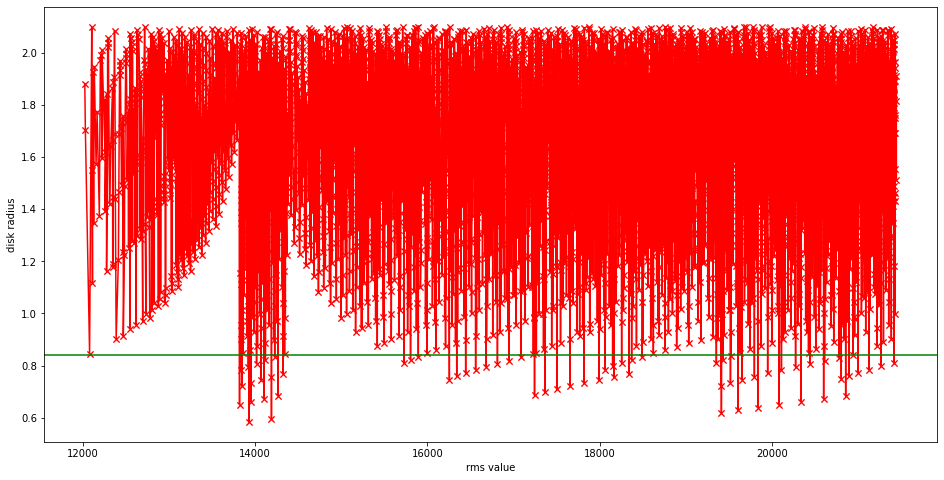

In [22]:
fig = plt.figure(figsize=(16, 8))
plt.plot(rms, disk_radius, 'r-x')
plt.gca().axhline(y=disk_radius_pds, color='g')
plt.xlabel('rms value')
plt.ylabel('disk radius')
plt.show()

Sorting by disk radius size gives us the smallest disk solutions.

In [23]:
sort_mask = np.argsort(disk_radius)
disk_radius_sorted = disk_radius[sort_mask]
inclination_sorted = inclination[sort_mask]
tilt_sorted = tilt[sort_mask]
dx_sorted = dx[sort_mask]
dy_sorted = dy[sort_mask]
rms_sorted = rms[sort_mask]


Below we plot the extracted solutions sorted by disk radius.

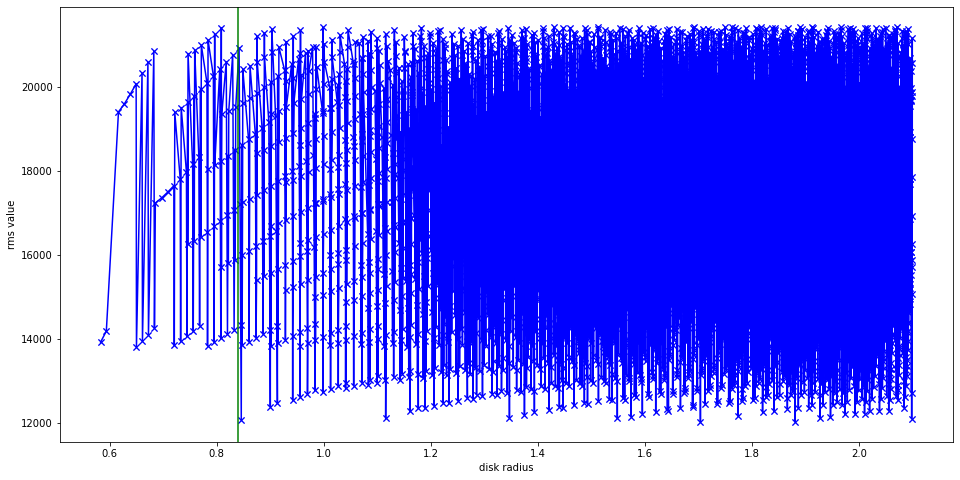

In [24]:
fig = plt.figure(figsize=(16, 8))
plt.plot(disk_radius_sorted, rms_sorted, 'b-x')
plt.gca().axvline(x=disk_radius_pds, color='g')
plt.xlabel('disk radius')
plt.ylabel('rms value')
plt.show()

#### PDS Ring System
Here we generate the PDS ring system based on the values from the paper

In [25]:
pds_rs_planet_radius = 0.5 # just for visualising the centre of the disk
pds_rs_inner_radius = np.zeros(1)
pds_rs_outer_radius = scale * disk_radius_pds * np.ones(1)
pds_rs_transmission = 0.9 * np.ones(1) # to ensure transparency

pds_rs = RingSystem(
    pds_rs_planet_radius, 
    pds_rs_inner_radius,
    pds_rs_outer_radius, 
    pds_rs_transmission,
    inclination_pds,
    tilt_pds
)               

We subsequently produce ring system patches for all the disc solutions extracted.

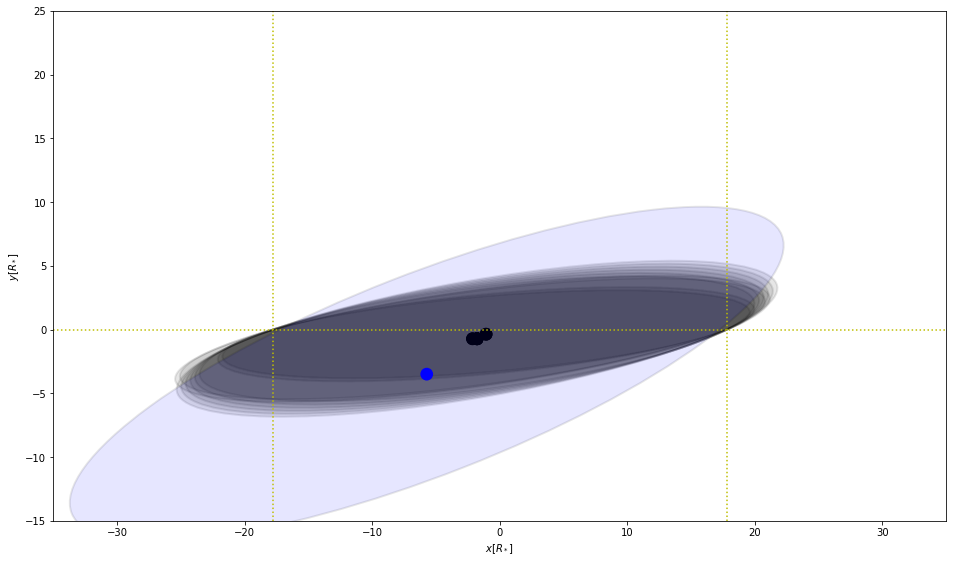

In [26]:
planet_radius = 0.5
inner_radius = np.zeros(1)
transmission = 0.9 * np.ones(1)

fig, ax = plt.subplots(1, figsize=(16, 12))
for k in range(20):
    if dy_sorted[k] > 0:
       continue

    rs = RingSystem(
        planet_radius, 
        inner_radius,
        scale * np.array([disk_radius_sorted[k]]),
        transmission,
        inclination_sorted[k],
        tilt_sorted[k]
    )

    ax = rs.plot(ax=ax, x_shift = scale * dx_sorted[k], y_shift = scale * dy_sorted[k])

ax = pds_rs.plot(ax=ax, x_shift = scale * centroid_shift_pds, y_shift = scale * impact_parameter_pds, face_color='blue')
ax.set_ylim(-15, 25)
ax.set_xlim(-35, 35)
ax.axvline(x = -0.5 * scale, color='y', ls=':')
ax.axvline(x =  0.5 * scale, color='y', ls=':')
ax.axhline(y = 0, color='y', ls=':')
plt.show()
    

Then we produce the figure that shows the gradient curves of the above disc solutions

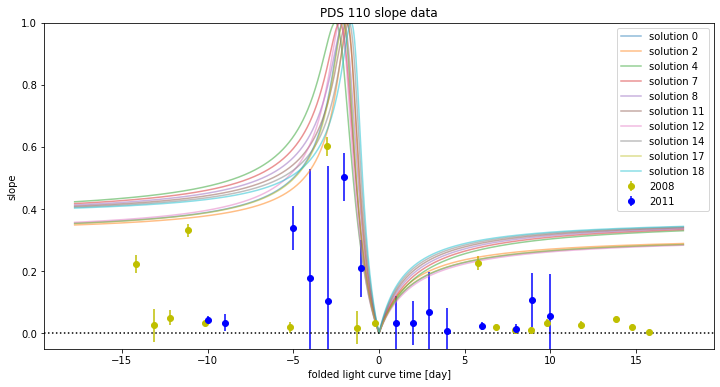

In [27]:
fig = plt.figure(figsize=(12, 6))
plt.errorbar(slope_time_wasp, orbital_scale * np.abs(slope_wasp), yerr=slope_error_wasp, fmt='o', color='y', label='2008')
plt.errorbar(slope_time_kelt, orbital_scale * np.abs(slope_kelt), yerr=slope_error_kelt, fmt='o', color='b', label='2011')
for k in range(20):
    if dy_sorted[k] > 0:
        continue
    solution_gradients = ring_gradients(positions, scale * dx_sorted[k], scale * dy_sorted[k], inclination_sorted[k], tilt_sorted[k])
    plt.plot(times, solution_gradients, alpha=0.5, label=f'solution {k}')
plt.ylim(-0.05, 1)
plt.gca().axhline(y=0, color='k', ls=':')
plt.xlabel('folded light curve time [day]')
plt.ylabel('slope')
plt.title('PDS 110 slope data')
plt.legend()
plt.show()

## Additional Analysis
In the previous analysis we left out the additional (and individual) scaling of each measured gradient by the transmission difference. Note that this is a precarious practice and has some limitations.
1. The scaled gradient can not exceed 1.
2. The transmission change should always be an upper bound to prevent over estimation of the measured gradients and cut away too much of the parameter space.
3. When unsure use a transmission change of 1.

#### Super WASP Eclipse from 2008
We first look at the eclipse measured by Super WASP

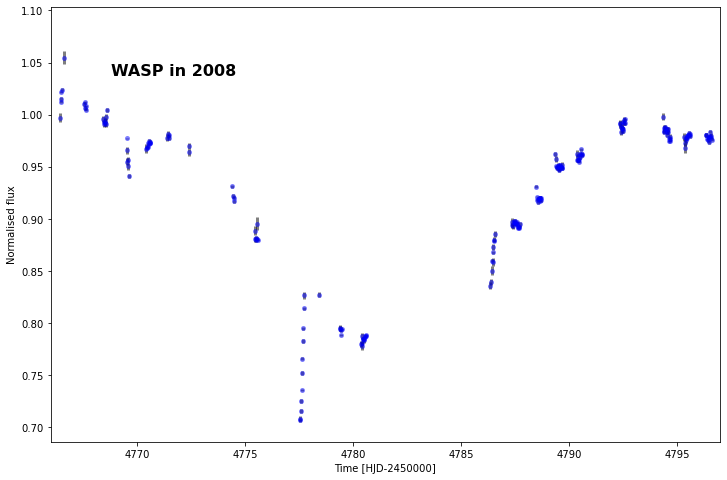

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.set_xlim(4766,4797)
ax1.text(0.09, 0.87, 'WASP in 2008', transform=ax1.transAxes, **tyb)
ax1.errorbar(time_wasp, flux_wasp, flux_error_wasp, mfc='blue', **tc)
ax1.set_xlabel('Time [HJD-2450000]')
ax1.set_ylabel('Normalised flux')
plt.show()

We look at all the individual nights to visualise the gradients and determine the transmission changes manually.

In [29]:
wasp_xlims = [(4766, 4767), (4767, 4768), (4768, 4769), (4769, 4770), (4770, 4771), 
              (4775, 4776), (4777, 4778), (4779, 4780), (4780, 4781), (4786, 4787),
              (4787, 4788), (4788, 4789), (4789, 4790), (4790, 4791), (4792, 4793),
              (4794, 4795), (4795, 4796), (4796, 4797)]
wasp_ylims = [(0.90, 1.10), (0.90, 1.10), (0.90, 1.10), (0.90, 1.10), (0.90, 1.10),
              (0.80, 1.00), (0.65, 0.85), (0.70, 0.90), (0.70, 0.90), (0.80, 1.00),
              (0.80, 1.00), (0.80, 1.00), (0.90, 1.10), (0.90, 1.10), (0.90, 1.10),
              (0.90, 1.10), (0.90, 1.10), (0.90, 1.10)]

Plot the nightly gradients

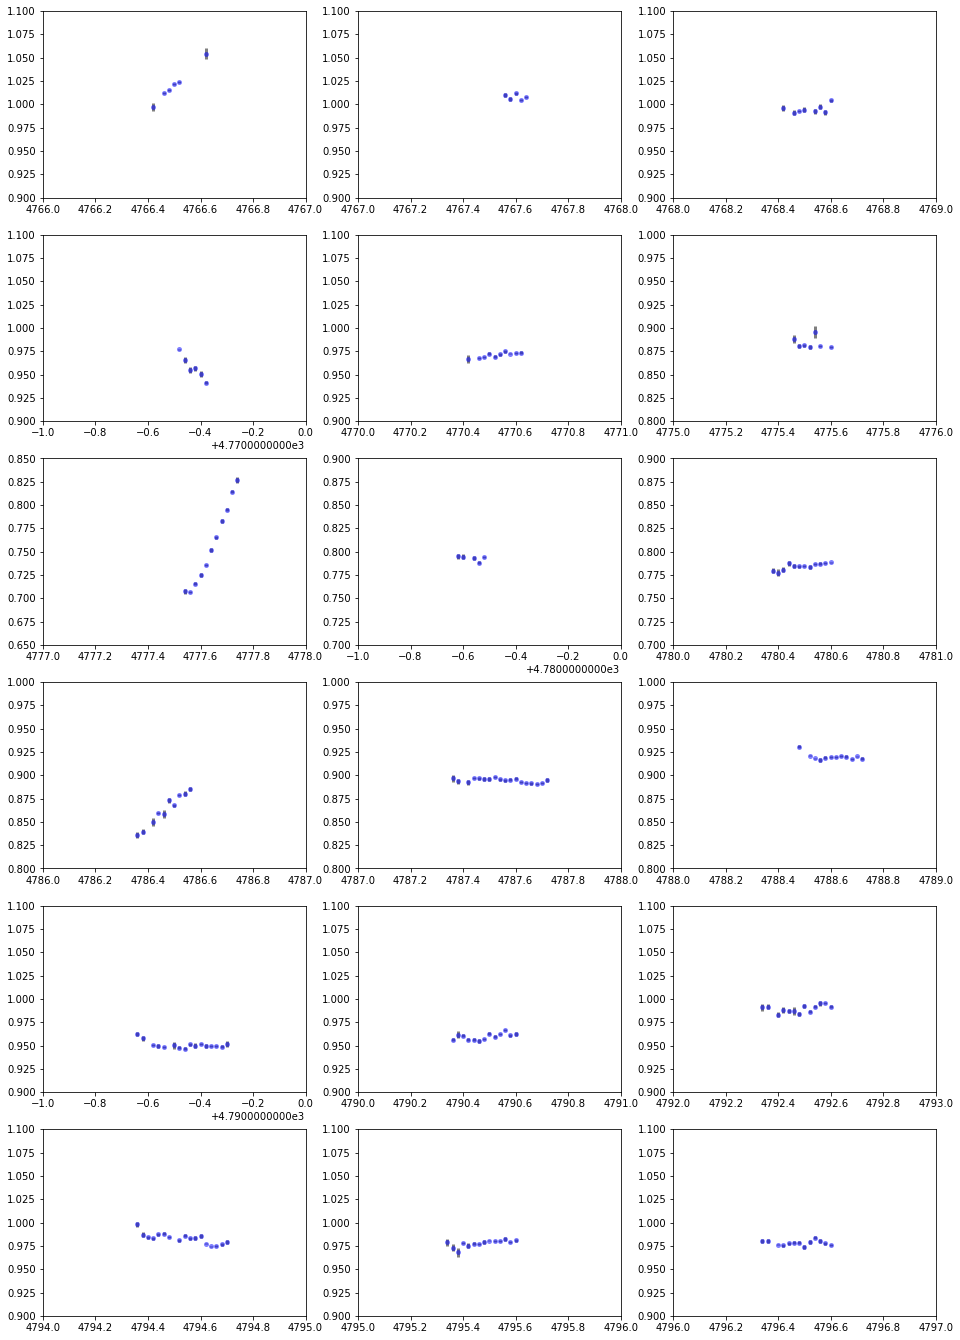

In [30]:
fig, axes = plt.subplots(6, 3, figsize=(16, 24))
for xlim, ylim, ax in zip(wasp_xlims, wasp_ylims, axes.flatten()):
    ax.errorbar(time_wasp, flux_wasp, flux_error_wasp, mfc='blue', **tc)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plt.show()

Observing the above subplots gives the following transmission changes

In [31]:
transmission_changes = np.ones(len(grid.gradients))

In [32]:
wasp_transmission_changes = np.array([1.000, 1.000, 1.000, 1.000, 0.975, 
                                      0.900, 1.000, 0.800, 0.800, 1.000, 
                                      0.900, 0.950, 0.950, 0.950, 1.000, 
                                      1.000, 1.000, 1.000])
transmission_changes[:18] = wasp_transmission_changes

In [33]:
grid.update_gradient_scaling(transmission_changes=transmission_changes)
grid.determine_gradient_fit()
measured_positions, scaled_gradients, measured_errors, _ = grid.get_gradients(masked=True)
measured_times = - measured_positions * eclipse_duration

2022-12-08 23:55:46,191 - INFO     - determine_gradient_fit: determining 33 gradient rms's
100%|██████████| 33/33 [00:02<00:00, 11.63it/s]


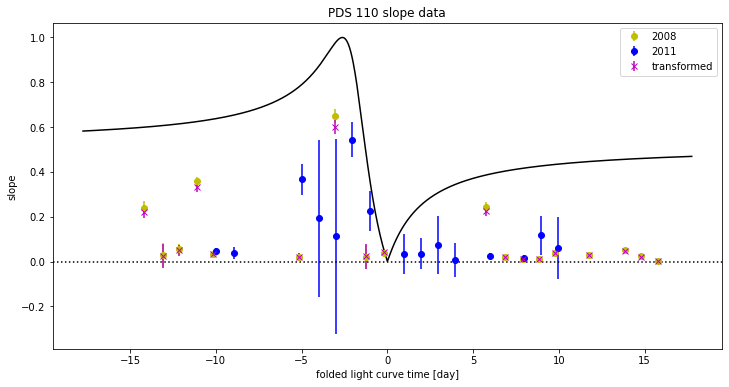

In [34]:
fig = plt.figure(figsize=(12, 6))
plt.errorbar(slope_time_wasp, np.abs(slope_wasp), yerr=slope_error_wasp, fmt='o', color='y', label='2008')
plt.errorbar(slope_time_kelt, np.abs(slope_kelt), yerr=slope_error_kelt, fmt='o', color='b', label='2011')
plt.errorbar(measured_times[:18], scaled_gradients[:18], yerr=measured_errors[:18], fmt='x', color='m', label='transformed')
plt.plot(times, gradients, 'k-')
plt.gca().axhline(y=0, color='k', ls=':')
plt.xlabel('folded light curve time [day]')
plt.ylabel('slope')
plt.title('PDS 110 slope data')
plt.legend()
plt.show()

We see that the 7th value now exceeds the limit of gradient_max = 1. Thus the transmission change needs to be restored to 1.

In [35]:
transmission_changes[6] = 1.000

#### KELT Eclipse from 2011
We secondly look at the eclipse measured by KELT

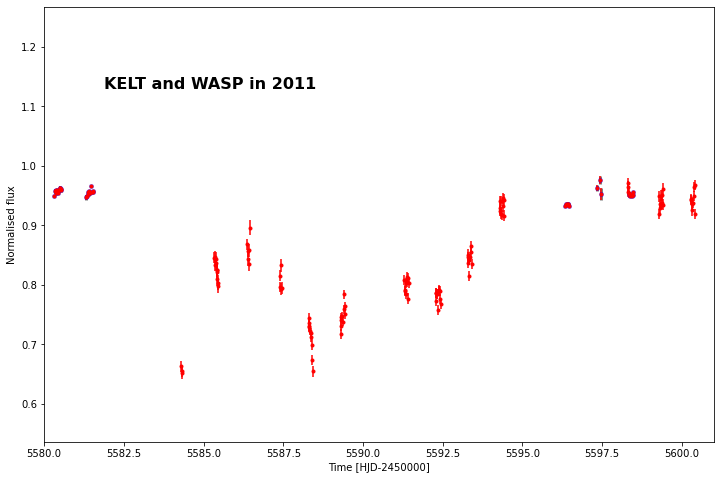

In [36]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(111)
ax2.set_xlim(5580,5601)
ax2.text(0.09, 0.84, 'KELT and WASP in 2011', transform=ax2.transAxes, **tyb)
ax2.errorbar(time_wasp, flux_wasp, flux_error_wasp, mfc='blue', **tc)
ax2.errorbar(time_kelt, flux_kelt, flux_error_kelt, fmt='.', color='red')
ax2.set_xlabel('Time [HJD-2450000]')
ax2.set_ylabel('Normalised flux')
plt.show()

In [37]:
kelt_xlims = [(5580, 5581), (5581, 5582), (5585, 5586), (5586, 5587), (5587, 5588),
              (5588, 5589), (5589, 5590), (5591, 5592), (5592, 5593), (5593, 5594),
              (5594, 5595), (5596, 5597), (5598, 5599), (5599, 5600), (5600, 5601)]

kelt_ylims = [(0.85, 1.05), (0.85, 1.05), (0.70, 0.90), (0.75, 0.95), (0.70, 0.90),
              (0.60, 0.80), (0.65, 0.85), (0.70, 0.90), (0.70, 0.90), (0.75, 0.95),
              (0.85, 1.05), (0.85, 1.05), (0.85, 1.05), (0.85, 1.05), (0.85, 1.05)]

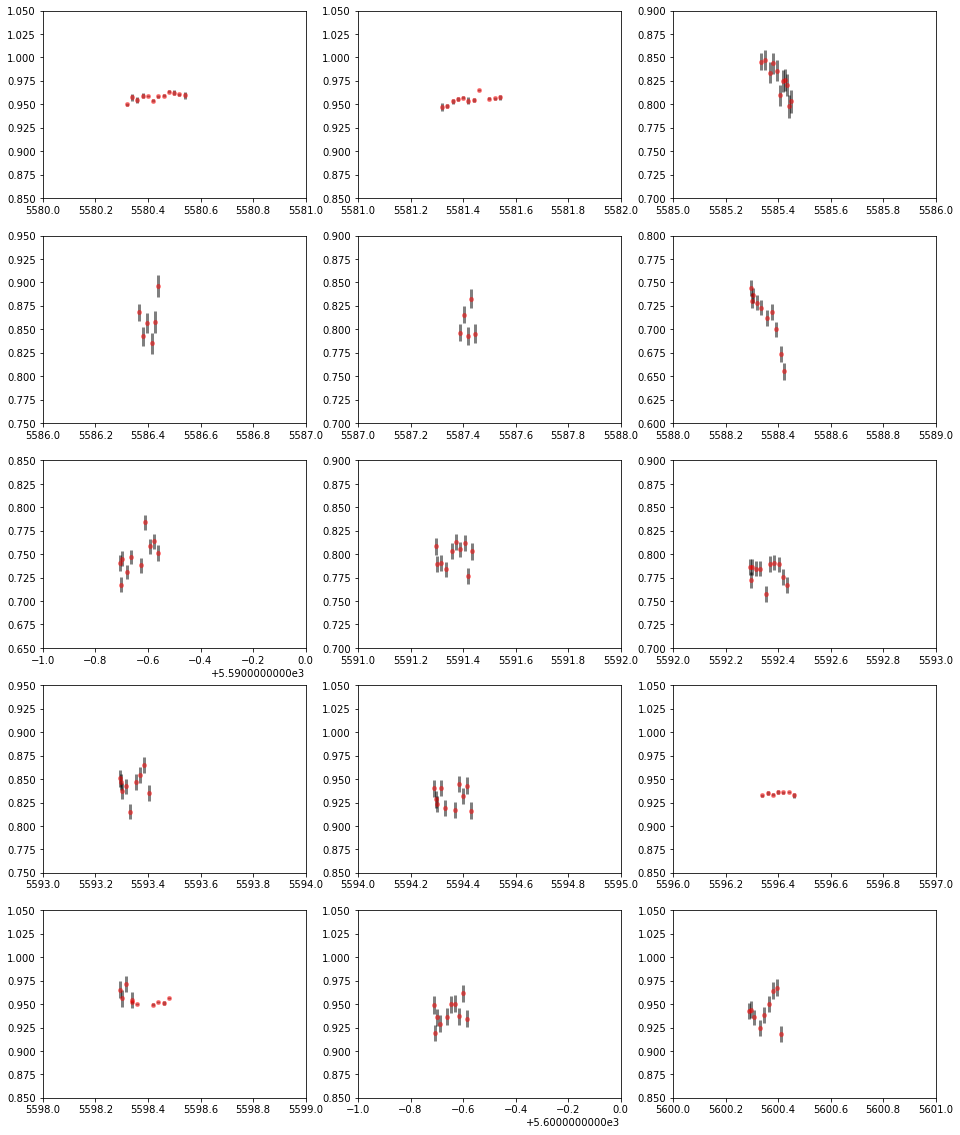

In [38]:
fig, axes = plt.subplots(5, 3, figsize=(16, 20))
for xlim, ylim, ax in zip(kelt_xlims, kelt_ylims, axes.flatten()):
    ax.errorbar(time_kelt, flux_kelt, flux_error_kelt, mfc='red', **tc)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plt.show()

Observing the above subplots gives the following transmission changes

In [39]:
kelt_transmission_changes = np.array([0.975, 0.975, 1.000, 0.900, 0.850, 
                                      1.000, 1.000, 0.800, 0.800, 0.875, 
                                      0.950, 0.950, 0.975, 0.975, 1.000])
transmission_changes[18:] = kelt_transmission_changes

In [40]:
print(f"{transmission_changes = }")

transmission_changes = array([1.   , 1.   , 1.   , 1.   , 0.975, 0.9  , 1.   , 0.8  , 0.8  ,
       1.   , 0.9  , 0.95 , 0.95 , 0.95 , 1.   , 1.   , 1.   , 1.   ,
       0.975, 0.975, 1.   , 0.9  , 0.85 , 1.   , 1.   , 0.8  , 0.8  ,
       0.875, 0.95 , 0.95 , 0.975, 0.975, 1.   ])


In [41]:
grid.update_gradient_scaling(transmission_changes=transmission_changes)
grid.determine_gradient_fit()
measured_positions, scaled_gradients, measured_errors, _ = grid.get_gradients(masked=True)
measured_times = - measured_positions * eclipse_duration

2022-12-08 23:56:08,391 - INFO     - determine_gradient_fit: determining 33 gradient rms's
100%|██████████| 33/33 [00:02<00:00, 12.09it/s]


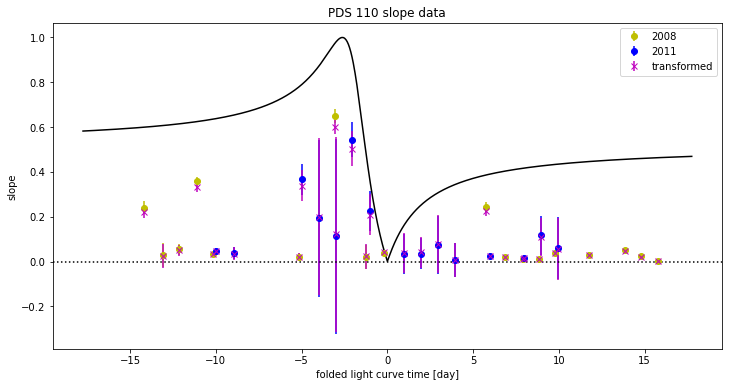

In [42]:
fig = plt.figure(figsize=(12, 6))
plt.errorbar(slope_time_wasp, np.abs(slope_wasp), yerr=slope_error_wasp, fmt='o', color='y', label='2008')
plt.errorbar(slope_time_kelt, np.abs(slope_kelt), yerr=slope_error_kelt, fmt='o', color='b', label='2011')
plt.errorbar(measured_times, scaled_gradients, yerr=measured_errors, fmt='x', color='m', label='transformed')
plt.plot(times, gradients, 'k-')
plt.gca().axhline(y=0, color='k', ls=':')
plt.xlabel('folded light curve time [day]')
plt.ylabel('slope')
plt.title('PDS 110 slope data')
plt.legend()
plt.show()

#### Solution Extraction
Once again we extract solutions and plot some of the best fit solutions with the smallest disk sizes.

In [43]:
rms_analysis, disk_radius_analysis, inclination_analysis, tilt_analysis, dx_analysis, dy_analysis = grid.extract_solutions(10000)
orbital_scale_analysis = grid.gradients[0].orbital_scale

2022-12-08 23:56:21,053 - INFO     - extract_solutions: extracting 10000 out of 859582 possible solutions
100%|██████████| 10000/10000 [39:54<00:00,  4.18it/s]    


In [44]:
sort_mask_analysis = np.argsort(disk_radius_analysis)
disk_radius_analysis_sorted = disk_radius_analysis[sort_mask_analysis]
inclination_analysis_sorted = inclination_analysis[sort_mask_analysis]
tilt_analysis_sorted = tilt_analysis[sort_mask_analysis]
dx_analysis_sorted = dx_analysis[sort_mask_analysis]
dy_analysis_sorted = dy_analysis[sort_mask_analysis]
rms_analysis_sorted = rms_analysis[sort_mask_analysis]


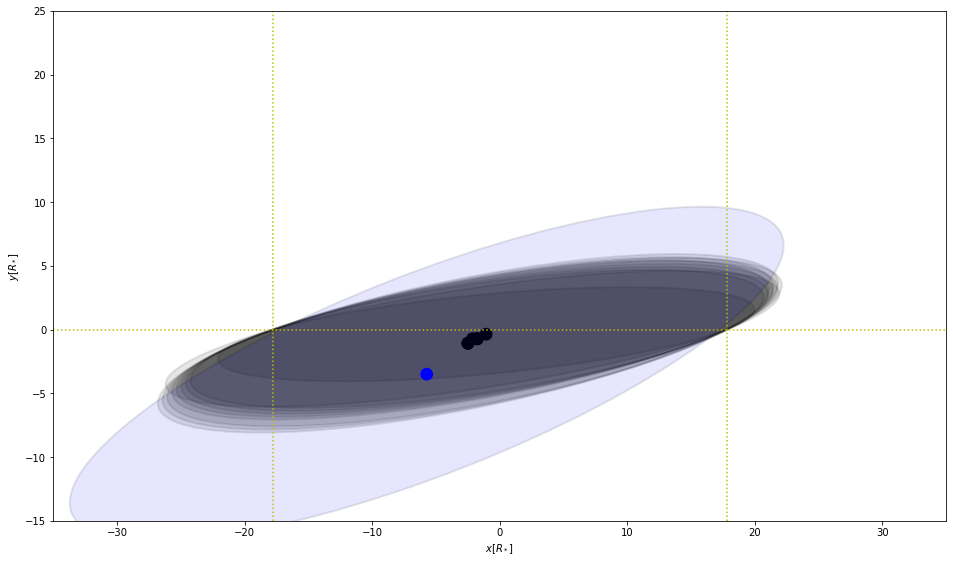

In [45]:
planet_radius = 0.5
inner_radius = np.zeros(1)
transmission = 0.9 * np.ones(1)

fig, ax = plt.subplots(1, figsize=(16, 12))
for k in range(20):
    if dy_analysis_sorted[k] > 0:
       continue

    rs = RingSystem(
        planet_radius, 
        inner_radius,
        scale * np.array([disk_radius_analysis_sorted[k]]),
        transmission,
        inclination_analysis_sorted[k],
        tilt_analysis_sorted[k]
    )

    ax = rs.plot(ax=ax, x_shift = scale * dx_analysis_sorted[k], y_shift = scale * dy_analysis_sorted[k])

ax = pds_rs.plot(ax=ax, x_shift = scale * centroid_shift_pds, y_shift = scale * impact_parameter_pds, face_color='blue')
ax.set_ylim(-15, 25)
ax.set_xlim(-35, 35)
ax.axvline(x = -0.5 * scale, color='y', ls=':')
ax.axvline(x =  0.5 * scale, color='y', ls=':')
ax.axhline(y = 0, color='y', ls=':')
plt.show()


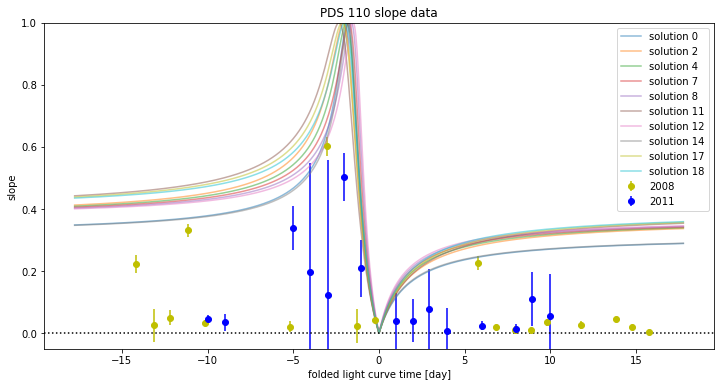

In [47]:
fig = plt.figure(figsize=(12, 6))
plt.errorbar(slope_time_wasp, orbital_scale * np.abs(slope_wasp) / transmission_changes[:18], 
    yerr=slope_error_wasp, fmt='o', color='y', label='2008')
plt.errorbar(slope_time_kelt, orbital_scale * np.abs(slope_kelt) / transmission_changes[18:], 
    yerr=slope_error_kelt, fmt='o', color='b', label='2011')
for k in range(20):
    if dy_sorted[k] > 0:
        continue
    solution_gradients = ring_gradients(positions, scale * dx_analysis_sorted[k], scale * dy_analysis_sorted[k], 
        inclination_analysis_sorted[k], tilt_analysis_sorted[k])
    plt.plot(times, solution_gradients, alpha=0.5, label=f'solution {k}')
plt.ylim(-0.05, 1)
plt.gca().axhline(y=0, color='k', ls=':')
plt.xlabel('folded light curve time [day]')
plt.ylabel('slope')
plt.title('PDS 110 slope data')
plt.legend()
plt.show()

#### Comparison
Here the results are compared for transmission scaling - yes and no.

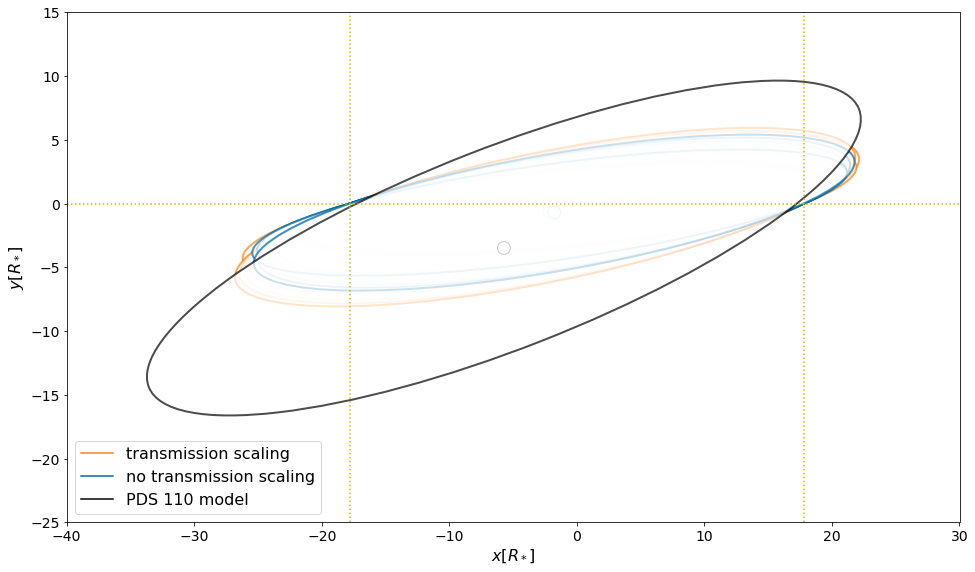

In [50]:
planet_radius = 0.5
inner_radius = np.zeros(1)
transmission = 0.9 * np.ones(1)

fig, ax = plt.subplots(1, figsize=(16, 12))
for k in range(20):

    if dy_analysis_sorted[k] > 0:
       continue

    rs = RingSystem(
        planet_radius, 
        inner_radius,
        scale * np.array([disk_radius_analysis_sorted[k]]),
        transmission,
        inclination_analysis_sorted[k],
        tilt_analysis_sorted[k]
    )

    ax = rs.plot(ax=ax, x_shift = scale * dx_analysis_sorted[k], y_shift = scale * dy_analysis_sorted[k], face_color='#FF800E')

for k in range(20):
    if dy_sorted[k] > 0:
       continue

    rs = RingSystem(
        planet_radius, 
        inner_radius,
        scale * np.array([disk_radius_sorted[k]]),
        transmission,
        inclination_sorted[k],
        tilt_sorted[k]
    )

    ax = rs.plot(ax=ax, x_shift = scale * dx_sorted[k], y_shift = scale * dy_sorted[k], face_color='#006BA4')
ax = pds_rs.plot(ax=ax, x_shift = scale * centroid_shift_pds, y_shift = scale * impact_parameter_pds, face_color='black')
ax.set_ylim(-25, 15)
ax.set_xlim(-40, 30)
ax.plot(-100, -100, color='#FF800E', ls='-', label='transmission scaling')
ax.plot(-100, -100, color='#006BA4', ls='-', label='no transmission scaling')
ax.plot(-100, -100, 'k-', label='PDS 110 model')
ax.axvline(x = -0.5 * scale, color='y', ls=':')
ax.axvline(x =  0.5 * scale, color='y', ls=':')
ax.axhline(y = 0, color='y', ls=':')
ax.tick_params(labelsize=14)
ax.legend(fontsize=16)

for p in ax.patches:
    fc = p.get_facecolor()
    p.set_edgecolor(fc)
    p.set_facecolor((1, 1, 1, 0))
    p.set_alpha(0.7)

ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
fig.savefig('../figures/figure_pds_ring_systems.pdf', pad_inches=0.2, bbox_inches='tight')
plt.show()


In [51]:
print((disk_radius_sorted[1] * scale * paper_star_radius).to(u.au))
print(inclination_sorted[1])
print(tilt_sorted[1])
print((dx_sorted[1] * scale * paper_star_radius).to(u.au))
print((dy_sorted[1] * scale * paper_star_radius).to(u.au))

0.21522413389902842 AU
81.74406586158405
175.10670091278868
-0.011073121109604145 AU
0.0036910403698680485 AU


In [52]:
grid.generate_hill_radius_mask(2.10)

In [53]:
hillmask = np.sum(grid.disk_radius.mask)
combmask = np.sum(grid.get_combined_mask())
total = np.prod(grid.parameters.grid_shape)

print(hillmask)
print(hillmask/total)
print(combmask - hillmask)
print((combmask - hillmask)/total)
print(combmask/total)


12403536
0.7656125150849022
2937683
0.1813294910541769
0.9469420061390792


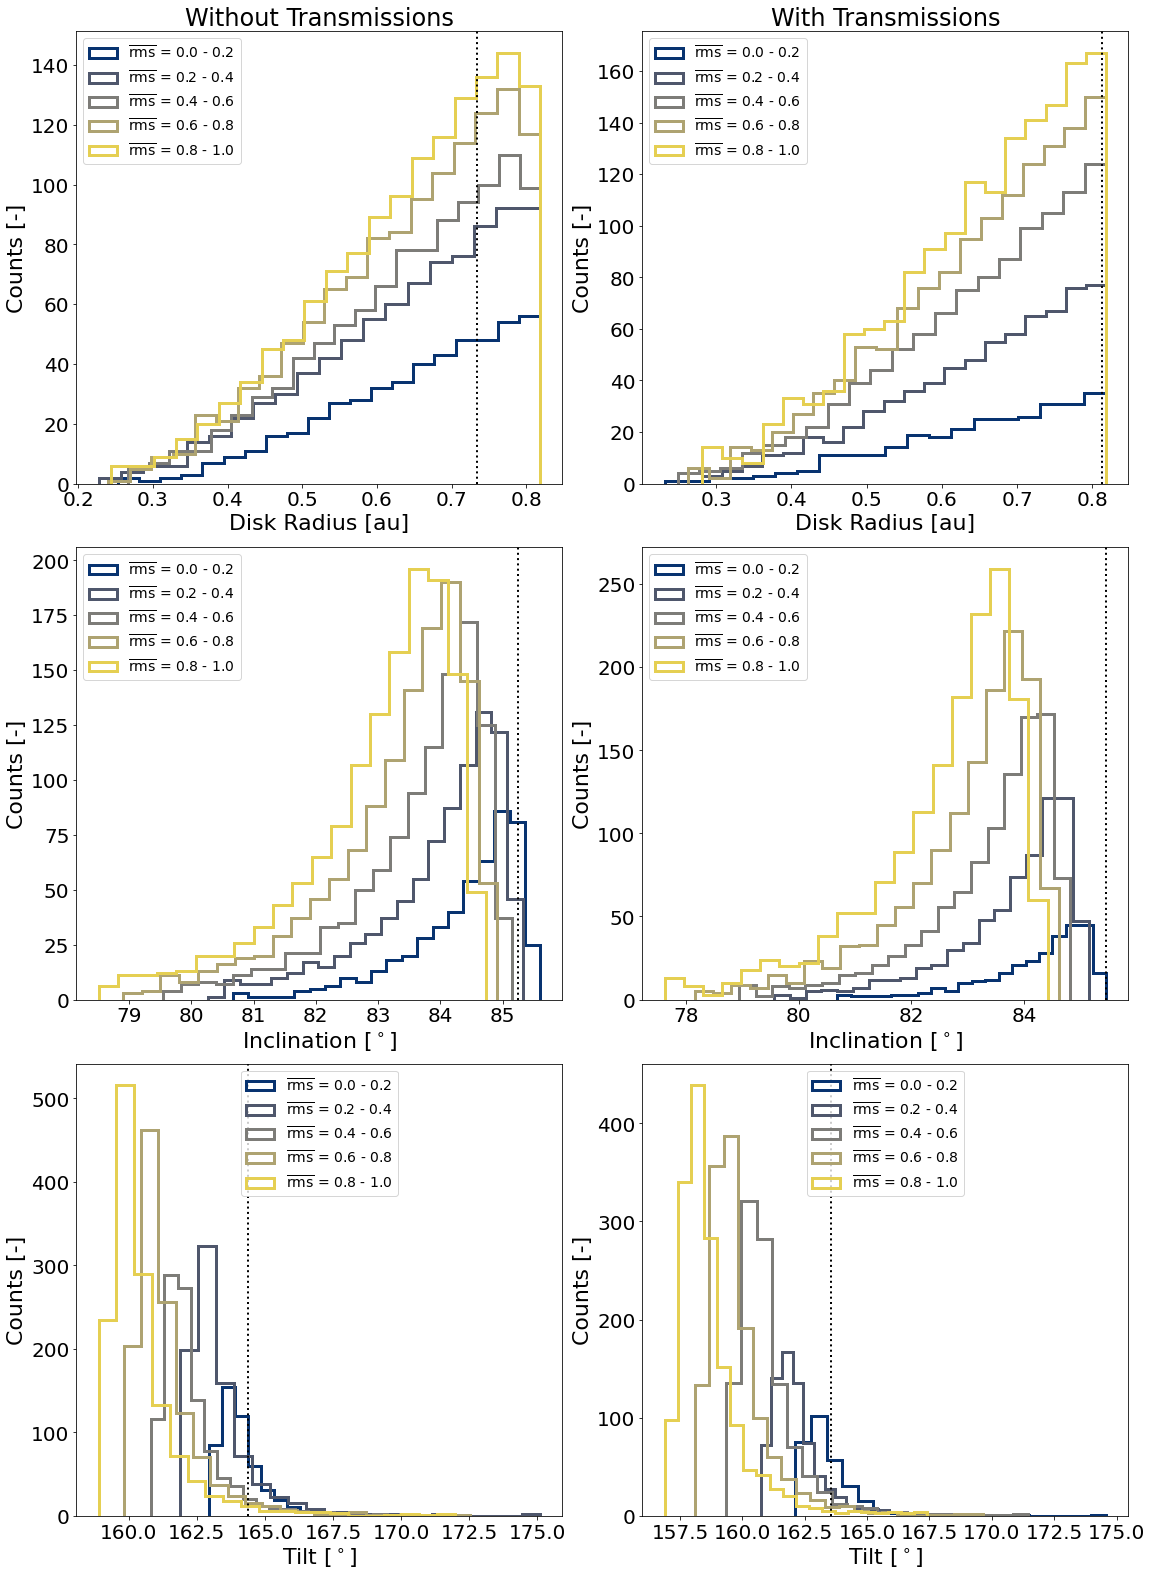

In [56]:
# without transmissions
mask = dy_sorted >= 0
rms_min = np.amin(rms_sorted)
rms_max = np.amax(rms_sorted)
rms_plot = (rms_sorted - rms_min) / (rms_max - rms_min)


# with transmissions
mask_analysis = dy_analysis_sorted >= 0
rms_analysis_min = np.amin(rms_analysis_sorted)
rms_analysis_max = np.amax(rms_analysis_sorted)
rms_analysis_plot = (rms_analysis_sorted - rms_analysis_min) / (rms_analysis_max - rms_analysis_min)

# plot features
lims = [(0., 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
colors = [0.1, 0.3, 0.5, 0.7, 0.9]
num_bins = 20

def make_plot(ax: plt.Axes, plot_data: np.ndarray, data_label: str, rms: np.ndarray, legend_loc: str = None) -> plt.Axes:
    data = np.copy(plot_data)
    ax.tick_params(labelsize=20)
    ax.set_xlabel(data_label, fontsize=22)
    ax.set_ylabel("Counts [-]", fontsize=22)
    for code, lim in zip(colors, lims):
        label = f"$\\overline{{\\mathrm{{rms}}}}$ = {lim[0]} - {lim[1]}"
        mask = (rms >= lim[0]) * (rms <= lim[1])
        color = plt.cm.get_cmap('cividis')(code)
        ax.hist(data[mask], bins=num_bins, edgecolor=color, fill=False, histtype="step", lw=3, label=label)
    ax.axvline(x=data[np.nanargmin(rms)], color='k', ls=':', lw=2)
    ax.legend(loc=legend_loc,fontsize=14)
    return ax

dr_sorted = disk_radius_sorted * (paper_eclipse_duration * paper_transverse_velocity).to(u.AU).value
dr_analysis_sorted = disk_radius_analysis_sorted * (paper_eclipse_duration * paper_transverse_velocity).to(u.AU).value
fig, axes = plt.subplots(3, 2, figsize=(16, 22))
axes[0, 0] = make_plot(axes[0, 0], dr_sorted[mask], 'Disk Radius [au]', rms_plot[mask], "upper left")
axes[1, 0] = make_plot(axes[1, 0], inclination_sorted[mask], 'Inclination [$^\circ$]', rms_plot[mask], "upper left")
axes[2, 0] = make_plot(axes[2, 0], tilt_sorted[mask], 'Tilt [$^\circ$]', rms_plot[mask], "upper center")
axes[0, 1] = make_plot(axes[0, 1], dr_analysis_sorted[mask_analysis], 'Disk Radius [au]', rms_analysis_plot[mask_analysis], "upper left")
axes[1, 1] = make_plot(axes[1, 1], inclination_analysis_sorted[mask_analysis], 'Inclination [$^\circ$]', rms_analysis_plot[mask_analysis], "upper left")
axes[2, 1] = make_plot(axes[2, 1], tilt_analysis_sorted[mask_analysis], 'Tilt [$^\circ$]', rms_analysis_plot[mask_analysis], "upper center")
axes[0, 0].set_title("Without Transmissions", fontsize=24)
axes[0, 1].set_title("With Transmissions", fontsize=24)
plt.tight_layout()
fig.savefig("../figures/pds_features.pdf")
plt.show()


0.5830988348326375
0.2273182358032013 AU


(0.5, 0.6)

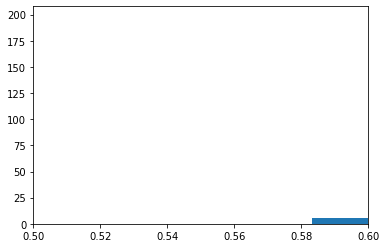

In [55]:
mask = (rms_plot >= 0) * (rms_plot <= 0.3)
DR = disk_radius_sorted[mask]
print(DR[0])
print((DR[0] * paper_eclipse_duration * paper_transverse_velocity).to(u.AU))

_ = plt.hist(DR, bins=20)
plt.xlim(0.5, 0.6)

